<a href="https://colab.research.google.com/github/pinballsurgeon/sweeping_analysis/blob/main/emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## installs

In [1]:
!pip install pytrends
!pip install joypy

  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=3d0932ab8a341bb699ac45d4aa9cbc0c29c4a792037b8ba6b0be592257912363
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends


## imports

In [2]:
import pandas 

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 



In [3]:
# configurations
config_dict = { 'analysis_start_year'  : 2021
              , 'analysis_start_month' : 1
              , 'analysis_end_year'    : 2021
              , 'analysis_end_month'   : 2
              , 'analysis_country'     : 'US' }


# topics
topics_explicit = ['flipflops', 'pumpkin', 'waffle', 'turkey', 'chicken', 'peanuts', 'baseball', 'basketball', 'football', 'kite', 'ice cream', 'hotdog', 'rocket']



In [4]:
df_total = pandas.DataFrame()

for topic in topics_explicit:


  pytrend = TrendReq()
  pytrend.build_payload(kw_list=[topic], timeframe='today 5-y')
  df = pytrend.interest_over_time()


#  df = dailydata.get_daily_data( topic
#                               , config_dict['analysis_start_year']
#                               , config_dict['analysis_start_month']
#                               , config_dict['analysis_end_year']
#                               , config_dict['analysis_end_month']
#                               , geo = config_dict['analysis_country']
#                               , verbose = False )
  
  df_total[topic] = df[topic]

# drop nans
df_total = df_total.dropna()

In [5]:
# capture features
df_features = df_total[topics_explicit]

In [6]:
# normalize
df_features=(df_features-df_features.mean())/df_features.std()

In [7]:

# normalize it all history (meanly)
df_total = (df_total-df_total.mean())/df_total.std()
df_features_recent = df_total[df_total.index > '1/1/2010']

# normalize it recent history (meanly)
df_features_recent = (df_features_recent-df_features_recent.mean())/df_features_recent.std()

# group by week, average occurences
df_agg = df_features
df_agg_recent = df_features_recent


In [8]:
# populate us
df_stk=pandas.DataFrame()
globalst=[]

# navigate hierarchy, each combination of WEEKNUM and FLOWER
for col in df_agg:           # flower
    for val in df_agg.index.weekofyear: # weeknum
        
        
        # time sensitive
        fs_val = df_agg[col][val]                   # full spectrum
        
        # in cases of no recent
        try:
            fs_val_recent = df_agg_recent[col][val] # recent spectrum
        except:
            fs_val_recent = 0
        
        
        # at this combo of flower/weeknum, check which source is greater, as its our limiter
        if fs_val > fs_val_recent:
            fs_max = fs_val
            fs_min = fs_val_recent
            fs_max_src = 'full'
        else:
            fs_max = fs_val_recent
            fs_min = fs_val
            fs_max_src = 'recent'
        
        
        # if max frequency signal greater than 0
        #if fs_max > 0 or fs_min > 0:
        #if fs_max > 0:
        if fs_max > 0.1 and fs_min > 0.1:
            
            # secondary source counter
            sec_i=1
            
            
            # iterate through each instance of max bin occurence, determining number of weeks written
            for x in range(0,int(abs(fs_max) * 100)):
            
            
                # full source
                if fs_max_src == 'full':
                    
                    if sec_i < int(abs(fs_min) * 100):
                    
                        lst=[val, val, col]
                        globalst.append(lst)
                    
                    else:
                        
                        lst=[val, None, col]
                        globalst.append(lst)                    
                    
                # recent source
                if sec_i < int(abs(fs_min) * 100):
                    
                    lst=[val, val, col]
                    globalst.append(lst)
                    
                else:
                        
                    lst=[None, val, col]
                    globalst.append(lst)                     
                    
                    
                sec_i+=1
                #print(sec_i)
                #print(df_agg[col][val])
                #print(df_agg_recent[col][val])
                
                
                #lst=[val, col]
                globalst.append(lst)
       
    
        #df_stk=df_stk.append(lst)

df_flat = pandas.DataFrame(globalst
                      ,columns=['WeekNum'
                               ,'WeekNum_Rct'
                               ,'Flower_Tot'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys


In [9]:
df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()
df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]
print(df_stats.columns)
df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

#df_stats['Name'] = '00' + str((df_stats['WeekNum mean']).astype(int)) #+ df_stats['Flower']
df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

i = 1
for index, row in df_stats.iterrows():
    #print(row['Flower'], row['Name'])
    df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])
    #df_flat['Flower'] = df_flat['Flower'].replace(row['Flower'], str(i) + row['Flower'])
    i+=1

print(df_flat)

Index(['Flower_Tot', 'WeekNum mean', 'WeekNum count', 'WeekNum_Rct mean',
       'WeekNum_Rct count'],
      dtype='object')
        WeekNum  WeekNum_Rct      Flower_Tot
0          10.0         10.0  2351 flipflops
1          10.0         10.0  2351 flipflops
2          10.0         10.0  2351 flipflops
3          10.0         10.0  2351 flipflops
4          10.0         10.0  2351 flipflops
...         ...          ...             ...
297117      8.0          8.0     4240 rocket
297118      8.0          8.0     4240 rocket
297119      8.0          8.0     4240 rocket
297120      NaN          8.0     4240 rocket
297121      NaN          8.0     4240 rocket

[297122 rows x 3 columns]


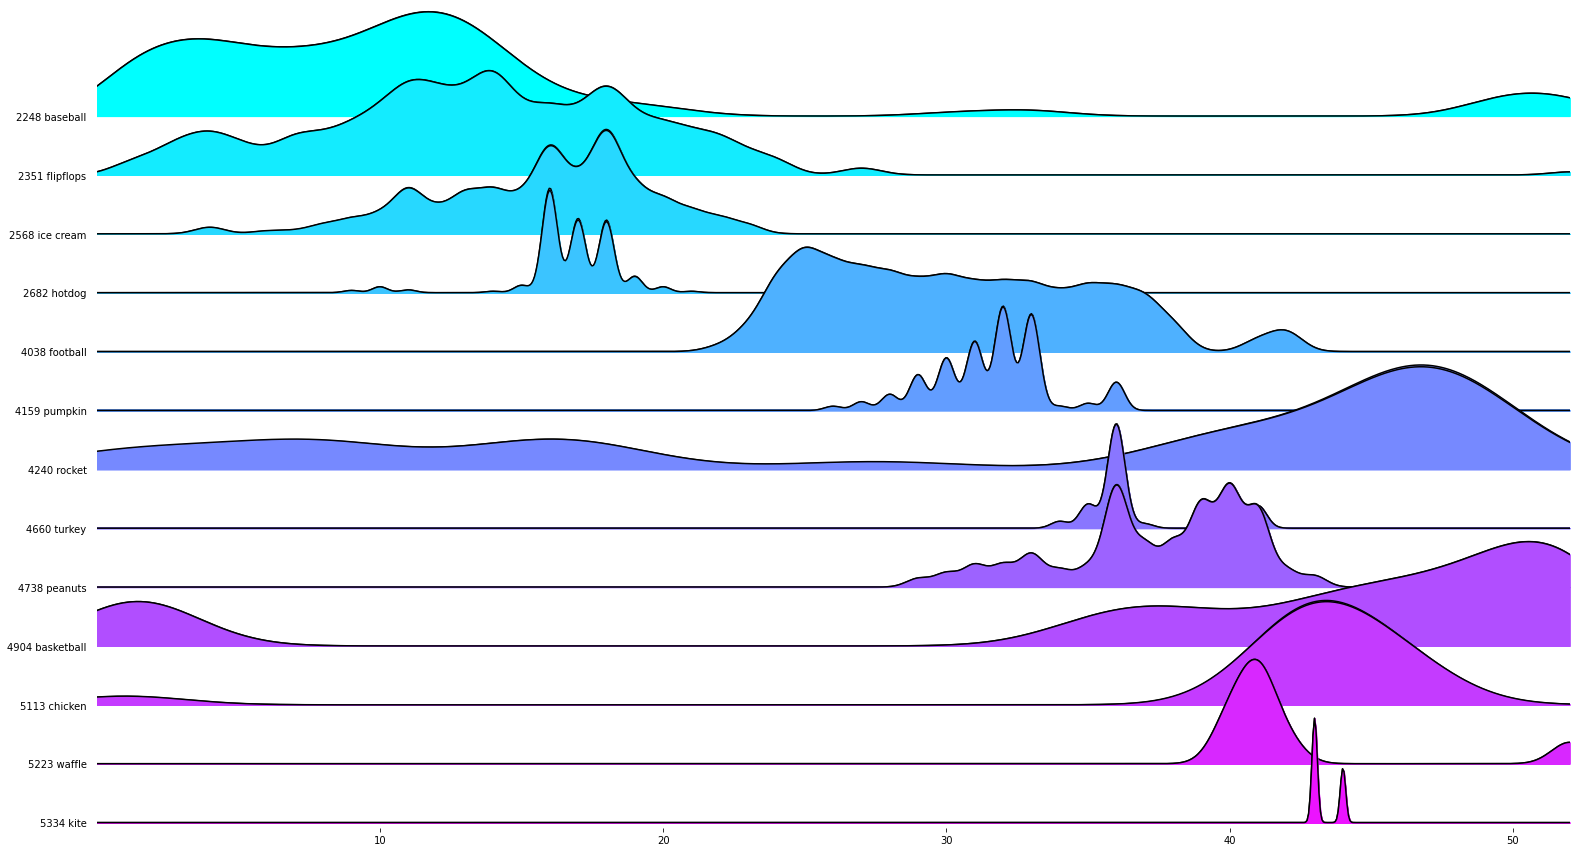

In [10]:
fig, axes = joypy.joyplot(df_flat
                          , column=['WeekNum', 'WeekNum_Rct']
                          , by='Flower_Tot'
                          , overlap=1.2
                          , fill=True
                          , figsize=(22,12)
                          , x_range = [0,52]
                          , colormap=cm.cool                         
                          , ylim='own'
                         )

plt.savefig('frank_jj.png')
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8da14daad0>]],
      dtype=object)

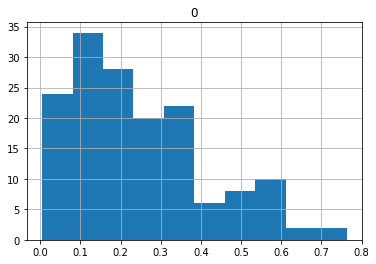

In [75]:

c = df_agg.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")



#df_slice = so[50:-13].to_frame()
df_slice = so[:-13].to_frame()
df_slice.hist()

In [35]:
df_slice

0
basketball rocket      0.141686
rocket     basketball  0.141686
basketball football    0.143275
football   basketball  0.143275
turkey     waffle      0.148037
...                         ...
baseball   peanuts     0.573515
           flipflops   0.675456
flipflops  baseball    0.675456
           ice cream   0.762712
ice cream  flipflops   0.762712

[106 rows x 1 columns]

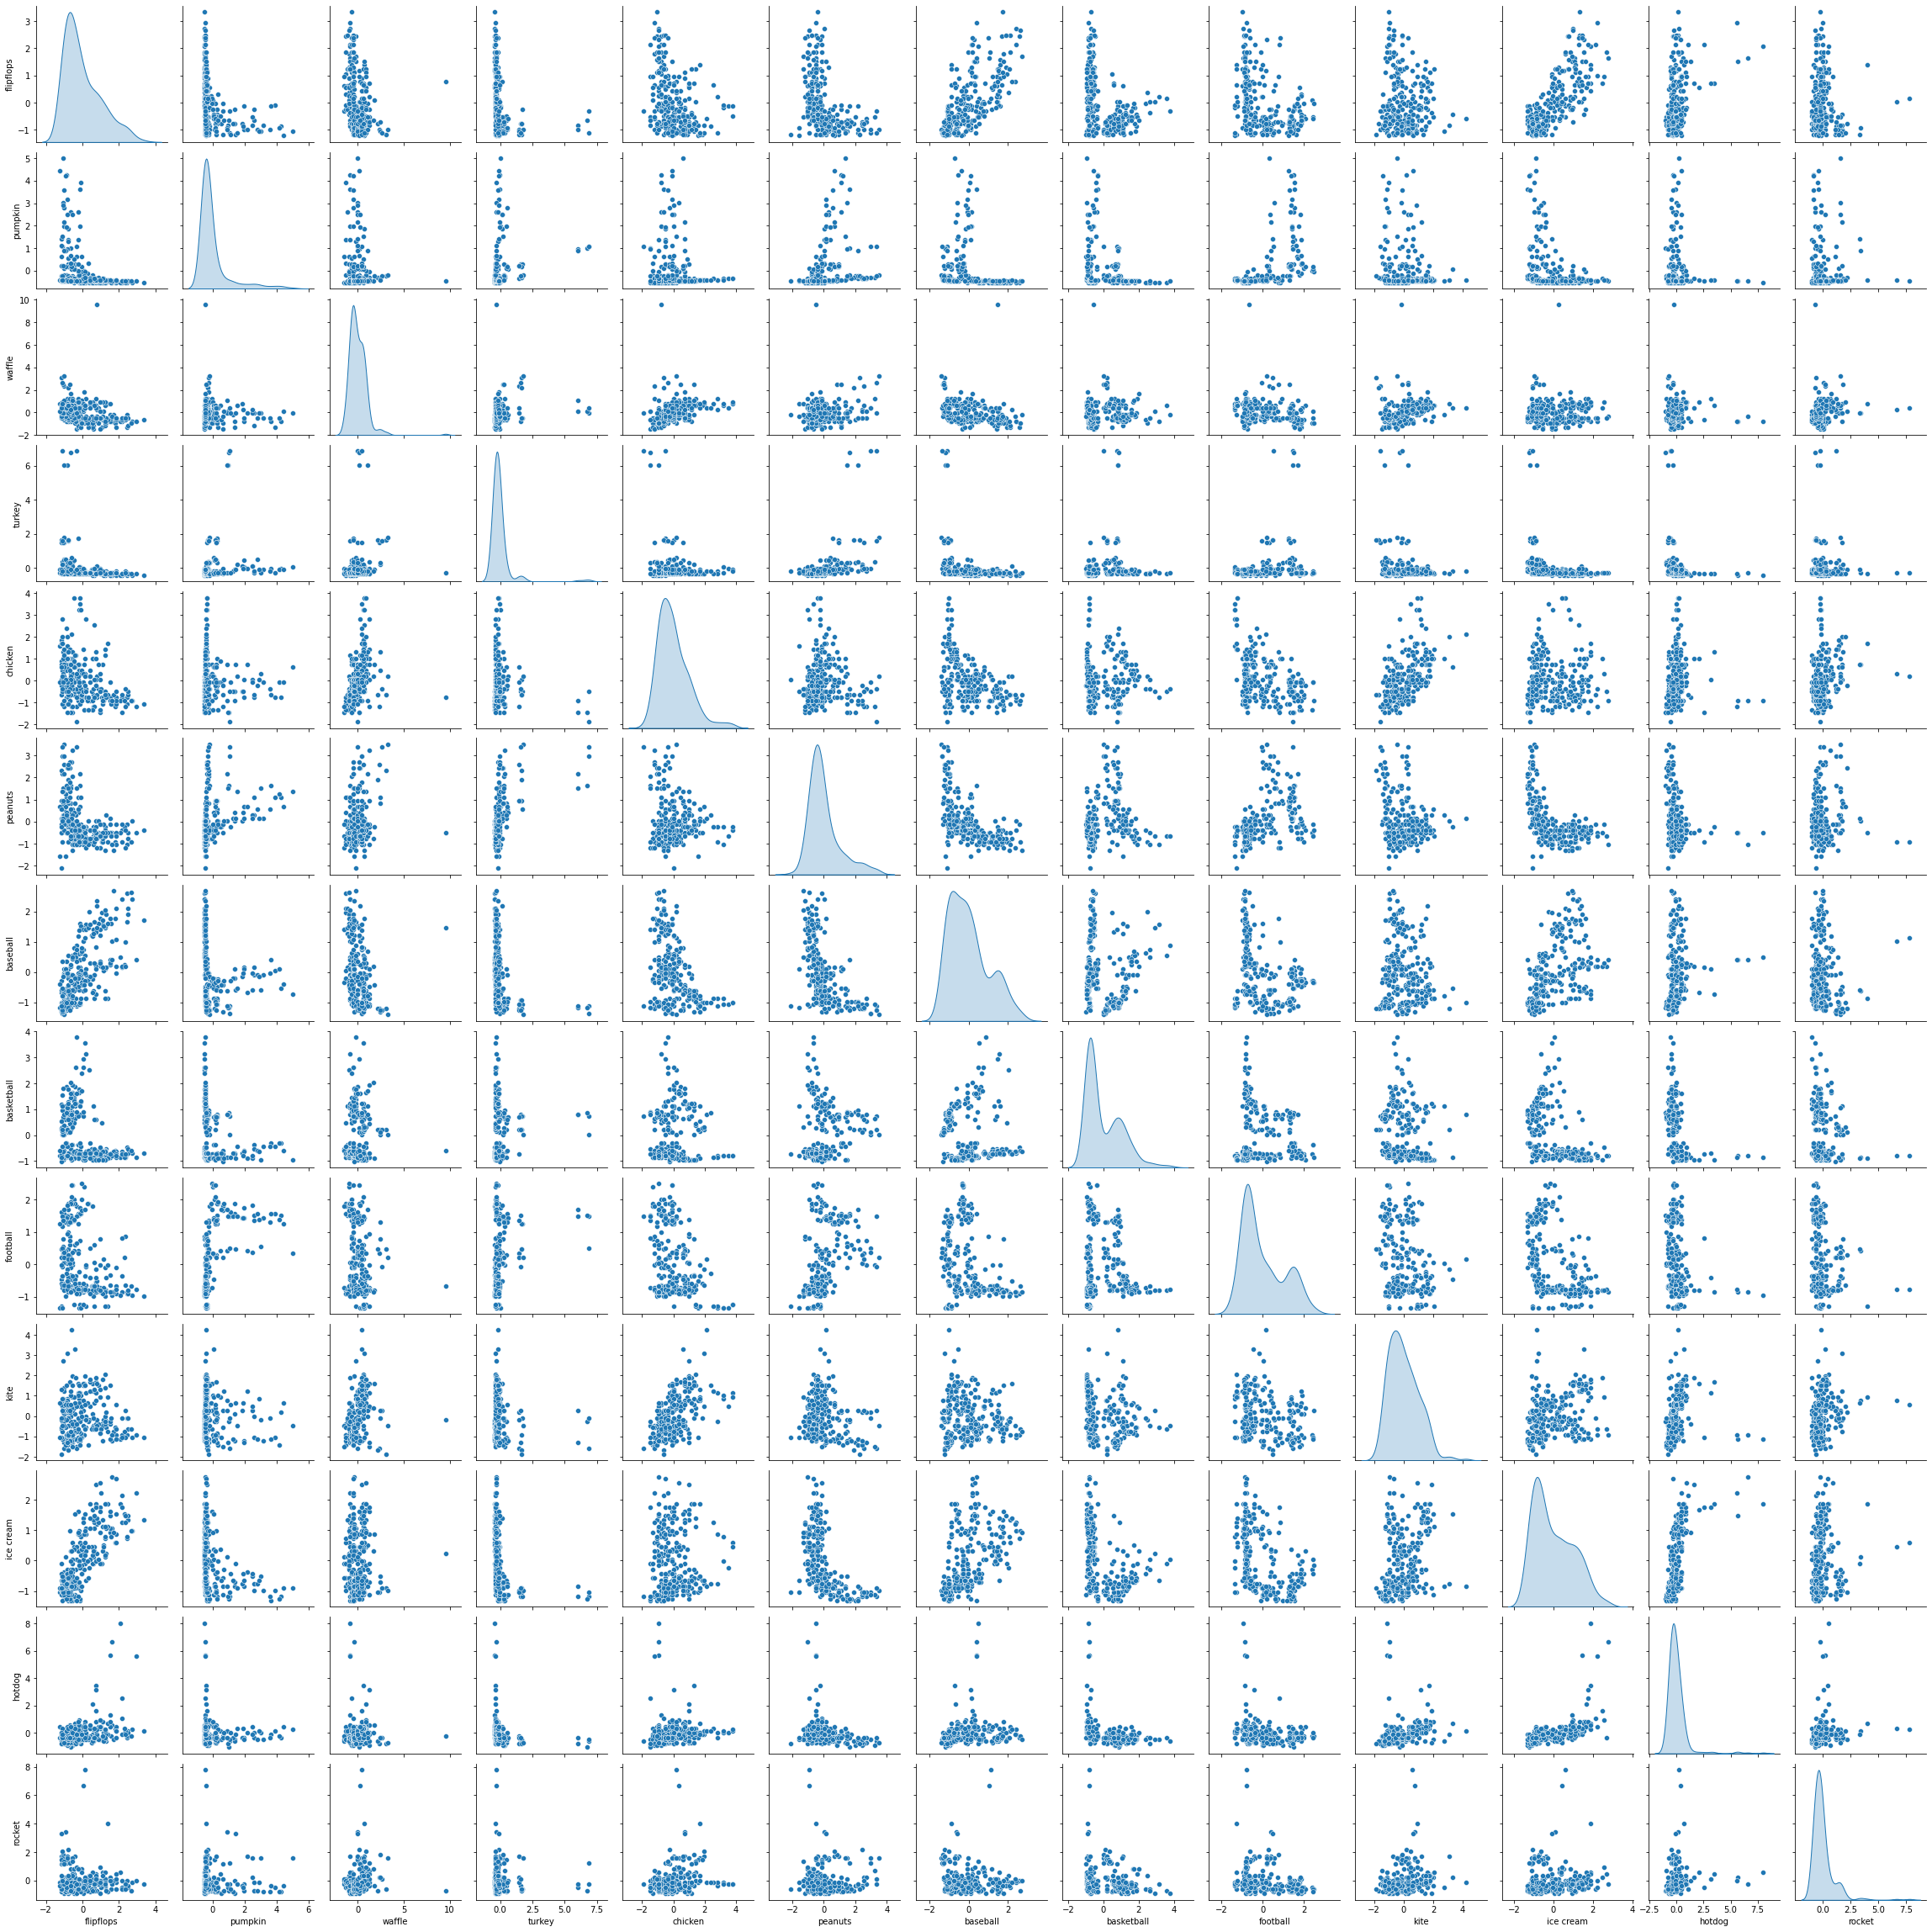

In [14]:
seaborn.pairplot(df_agg,diag_kind = 'kde',kind = 'scatter',palette = 'husl')

In [59]:
df_slice[]

0
rocket    turkey      0.004887
turkey    rocket      0.004887
pumpkin   rocket      0.011166
rocket    pumpkin     0.011166
waffle    basketball  0.016962
...                        ...
baseball  peanuts     0.573515
          flipflops   0.675456
flipflops baseball    0.675456
          ice cream   0.762712
ice cream flipflops   0.762712

[156 rows x 1 columns]

node degree clustering
rocket 12 1.0
turkey 12 1.0
pumpkin 12 1.0
waffle 12 1.0
basketball 12 1.0
ice cream 12 1.0
chicken 12 1.0
hotdog 12 1.0
peanuts 12 1.0
flipflops 12 1.0
kite 12 1.0
baseball 12 1.0
football 12 1.0
#/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-8fa4f30e-1b69-4d13-96fe-3fa82701a3ae.json
# GMT Sun Mar  6 02:48:39 2022
# 
rocket turkey pumpkin peanuts ice cream baseball flipflops hotdog basketball football waffle kite chicken
turkey basketball waffle kite hotdog chicken pumpkin flipflops football ice cream baseball peanuts
pumpkin hotdog waffle chicken kite baseball basketball peanuts flipflops ice cream football
waffle basketball ice cream hotdog football peanuts flipflops baseball kite chicken
basketball chicken baseball kite football peanuts hotdog flipflops ice cream
ice cream chicken kite football baseball peanuts hotdog flipflops
chicken hotdog peanuts football flipflops baseball kite
hotdog baseball k

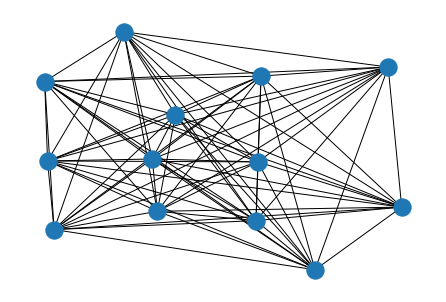

In [83]:
from networkx import *
import networkx as nx
import sys

n=10 # 10 nodes
m=20 # 20 edges

#G=gnm_random_graph(n,m)
#G=nx.from_pandas_dataframe(df_slice, 0, 'b', ['weight', 'cost'])
G = nx.from_pandas_edgelist(df_slice, 'source', 'target', ['weight'])

# some properties
print("node degree clustering")
for v in nodes(G):
    print(v,degree(G,v),clustering(G,v))

# print the adjacency list to terminal 
write_adjlist(G,sys.stdout)
draw(G)

In [65]:
import numpy as np
rng = np.random.RandomState(seed=5)

ints = rng.randint(1, 11, size=(3, 2))

ints

array([[ 4,  7],
       [ 7,  1],
       [10,  9]])

In [79]:
df_slice = df_slice.reset_index()

In [81]:
#df_slice.columns(["l","weight", "cost"])


df_slice.columns = ['source','target','weight']

In [82]:
df_slice

,source,target,weight
0,rocket,turkey,0.004887
1,turkey,rocket,0.004887
2,pumpkin,rocket,0.011166
3,rocket,pumpkin,0.011166
4,waffle,basketball,0.016962
...,...,...,...
151,baseball,peanuts,0.573515
152,baseball,flipflops,0.675456
153,flipflops,baseball,0.675456
154,flipflops,ice cream,0.762712
